In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip

--2024-10-04 02:57:22--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  30.2MB/s    in 10s     

2024-10-04 02:57:33 (26.2 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]

--2024-10-04 02:57:33--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘GTSRB_Final_Test_Images.zip’

GTSRB_Final_Test_Im 100%[===================>]  84.8

In [ ]:
!unzip GTSRB_Final_Training_Images.zip -d GTSRB_Final_Training_Images
!unzip GTSRB_Final_Test_Images.zip -d GTSRB_Final_Test_Images

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/07632.ppm  
  inflating: GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/07633.ppm  
  inflating: GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/07634.ppm  
  inflating: GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/07635.ppm  
  inflating: GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/07636.ppm  
  inflating: GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/07637.ppm  
  inflating: GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/07638.ppm  
  inflating: GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/07639.ppm  
  inflating: GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/07640.ppm  
  inflating: GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/07641.ppm  
  inflating: GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/07642.ppm  
  inflating: GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/07643.ppm  
  inflating: GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/07644.ppm  


In [10]:
import os
import shutil

!mkdir -p GTSRB/Train
!mkdir -p GTSRB/Test

!mv GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/* GTSRB/Train/

!mv GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/* GTSRB/Test/

!rm -rf GTSRB_Final_Training_Images GTSRB_Final_Test_Images

mv: cannot stat 'GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/*': No such file or directory
mv: cannot stat 'GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/*': No such file or directory


In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [12]:
def load_gtsrb_data(data_dir, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = data.random_split(dataset, [train_size, test_size])

    train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, len(dataset.classes)



In [13]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [14]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    loss_values = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function Over Epochs')
    plt.legend()
    plt.show()



In [15]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    final_accuracy = 100 * correct / total
    print(f'Final Test Accuracy: {final_accuracy:.2f}%')



Epoch [1/10], Loss: 0.5728
Epoch [2/10], Loss: 0.5270
Epoch [3/10], Loss: 0.5043
Epoch [4/10], Loss: 0.4856
Epoch [5/10], Loss: 0.4751
Epoch [6/10], Loss: 0.4500
Epoch [7/10], Loss: 0.4394
Epoch [8/10], Loss: 0.4240
Epoch [9/10], Loss: 0.4076
Epoch [10/10], Loss: 0.4000


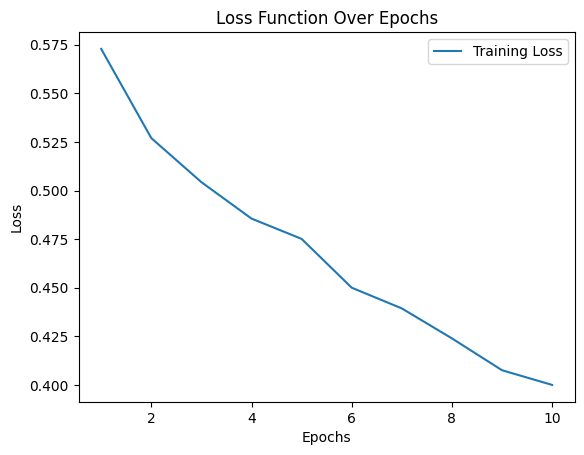

Final Test Accuracy: 80.90%


In [19]:
if __name__ == '__main__':
    data_dir = './GTSRB'

    batch_size = 64
    train_loader, test_loader, num_classes = load_gtsrb_data(data_dir, batch_size=batch_size)

    input_size = 32*32*3
    hidden_size = 256
    learning_rate = 0.001

    model = MLP(input_size, hidden_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_model(model, train_loader, criterion, optimizer, num_epochs=10)
    test_model(model, test_loader)
